# Decoding position from firing rates 

In this example we show how position can be decoded from neural firing rates. For this you will use  sklearn's linear regression model and compare it to sklearns gaussian process regression model. 

The plan is as follows. 
1. Initialise a 2D `Environment` an `Agent` and some populations of various types of `Neurons` 
1. Explore the environment for 5 minutes, then train decoders to map firing rates to positions from the "training" data generates.
1. Explore for 1 extra minute. Decode position from this "testing" data. Compare to the true position.


In [1]:
from ratinabox import *
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import PlaceCells,GridCells,BoundaryVectorCells

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
#Leave this as False. 
#For paper/readme production I use a plotting library (tomplotlib) to format and save figures. Without this they will still show but not save. 
if False: 
    import tomplotlib.tomplotlib as tpl
    tpl.figureDirectory = "../figures/"
    tpl.setColorscheme(colorscheme=2)
    save_plots = True
else:
    save_plots = False

First make a function `train_decoder()` which takes in a population of `Neurons` and trains two decoders (Gaussian process and linear ridge regression) on firing rate and position data stored in the `Neurins` class history dataframe. These decoders are saved back into the class itself, as attributes. 

A second function `decode_position()` takes a population of `Neurons` and decodes position from firing rate data in is history data frame and the decoders we just trained. 

In [3]:
def train_decoder(Neurons,t_start=None,t_end=None):
    """t_start and t_end allow you to pick the poritions of the saved data to train on."""
    #Get training data
    t = np.array(Neurons.history['t'])
    if t_start is None: i_start = 0
    else: i_start = np.argmin(np.abs(t-t_start))
    if t_end is None: i_end = -1
    else: i_end = np.argmin(np.abs(t-t_end))
    t = t[i_start:i_end][::5] #subsample data for training (most of it is redundant anyway)
    fr = np.array(Neurons.history['firingrate'])[i_start:i_end][::5]
    pos = np.array(Neurons.Agent.history['pos'])[i_start:i_end][::5]
    #Initialise and fit model
    from sklearn.gaussian_process.kernels import RBF
    model_GP = GaussianProcessRegressor(alpha=0.01, kernel=RBF(1
    *np.sqrt(Neurons.n/20), #<-- kernel size scales with typical input size ~sqrt(N)
    length_scale_bounds="fixed"
    ))
    model_LR = Ridge(alpha=0.01)
    model_GP.fit(fr,pos)    
    model_LR.fit(fr,pos)    
    #Save models into Neurons class for later use
    Neurons.decoding_model_GP = model_GP
    Neurons.decoding_model_LR = model_LR
    return 

def decode_position(Neurons,t_start=None,t_end=None):
    """t_start and t_end allow you to pick the poritions of the saved data to train on.
    Returns a list of times and decoded positions"""
    #Get testing data
    t = np.array(Neurons.history['t'])
    if t_start is None: i_start = 0
    else: i_start = np.argmin(np.abs(t-t_start))
    if t_end is None: i_end = -1
    else: i_end = np.argmin(np.abs(t-t_end))
    t = t[i_start:i_end]
    fr = np.array(Neurons.history['firingrate'])[i_start:i_end]
    #decode position from the data and using the decoder saved in the  Neurons class 
    decoded_position_GP = Neurons.decoding_model_GP.predict(fr)
    decoded_position_LR = Neurons.decoding_model_LR.predict(fr)
    return (t, decoded_position_GP, decoded_position_LR)

Initialise Environment, Agent, and cell populations. We will compare place cells, grid cells and boundary vectory cells. 

In [4]:
np.random.seed(10) #make reproducible

Env = Environment()
Env.add_wall(np.array([[0.4,0],[0.4,0.4]]))
Ag = Agent(Env, params={'dt':50e-3})


PCs = PlaceCells(Ag,params={'description':'gaussian_threshold','widths':0.4,'n':20,'color':'C1'})
GCs = GridCells(Ag,params={'n':20,'color':'C2'},)
BVCs = BoundaryVectorCells(Ag,params={'n':20,'color':'C3'})

Generate training data (5 minutes of random exploration)...

100%|██████████| 6000/6000 [00:08<00:00, 699.37it/s]


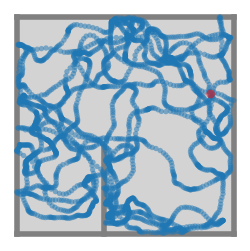

In [5]:
np.random.seed(9)
from tqdm import tqdm 
for i in tqdm(range(int(5*60/Ag.dt))):
    Ag.update()
    PCs.update()
    GCs.update()
    BVCs.update()

fig_t, ax_t = Ag.plot_trajectory(alpha=0.5)

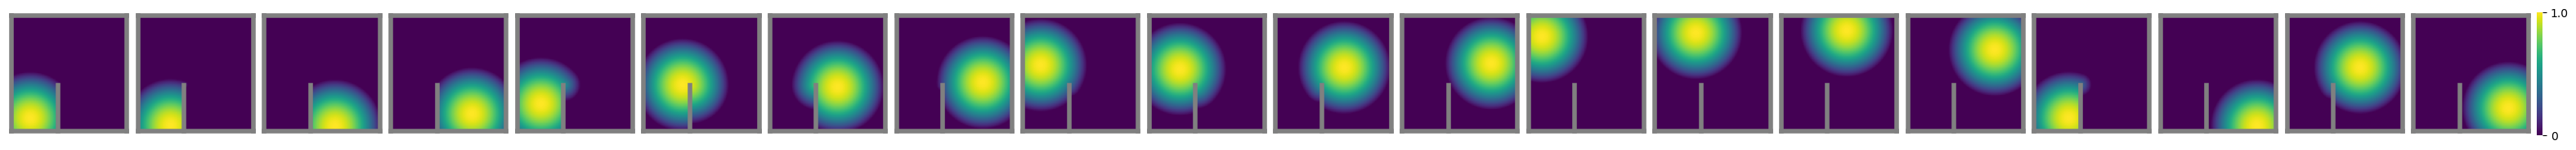

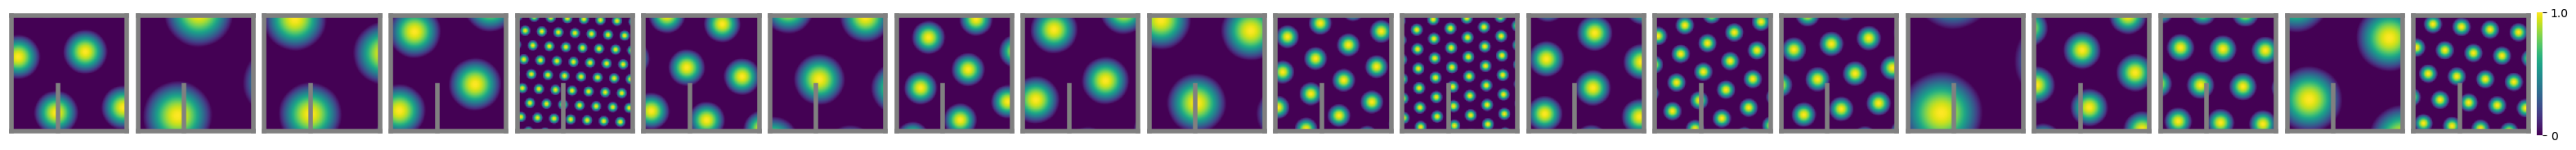

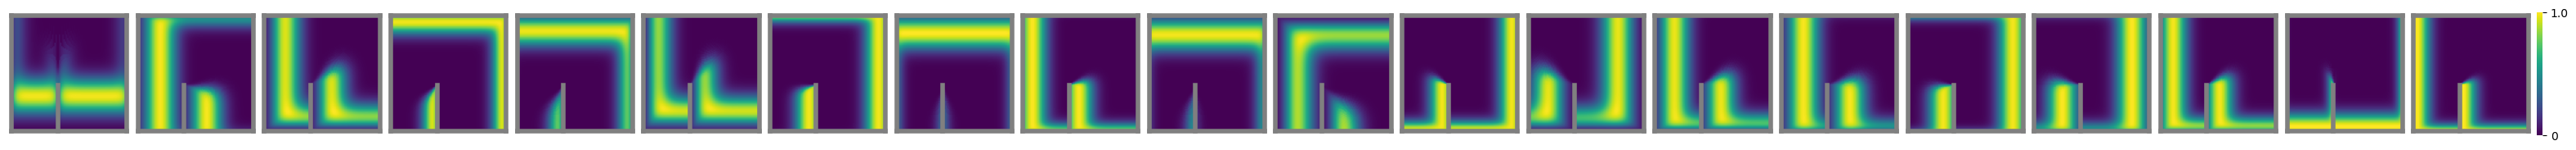

In [6]:
fig, ax = PCs.plot_rate_map(chosen_neurons='all')
if save_plots == True: tpl.saveFigure(fig, "PCs")
fig, ax = GCs.plot_rate_map(chosen_neurons='all')
if save_plots == True: tpl.saveFigure(fig, "GCs")
fig, ax = BVCs.plot_rate_map(chosen_neurons='all')
if save_plots == True: tpl.saveFigure(fig, "BVCs")

...and train decoder models.

In [7]:
train_decoder(PCs)
train_decoder(GCs)
train_decoder(BVCs)

Now generate an additional minute of testing data and "decode" position from it.

100%|██████████| 1200/1200 [00:01<00:00, 705.97it/s]


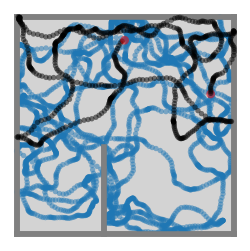

In [8]:
np.random.seed(10)
for i in tqdm(range(int(60/Ag.dt))):
    Ag.update()
    PCs.update()
    GCs.update()
    BVCs.update()

fig_t, ax_t = Ag.plot_trajectory(fig=fig_t, ax=ax_t,t_start=Ag.t-60,color='black',alpha=0.5)
if save_plots == True: tpl.saveFigure(fig_t,"data")
fig_t


In [9]:
t, pos_PCs_GP, pos_PCs_LR = decode_position(PCs,t_start=Ag.t-60)
t, pos_GCs_GP, pos_GCs_LR = decode_position(GCs,t_start=Ag.t-60)
t, pos_BVCs_GP, pos_BVCs_LR = decode_position(BVCs,t_start=Ag.t-60)

Visualise results: blue is the ground truth (real position) whereas coloured traces are the decodings. Compare the Gaussian process regression to linear regression

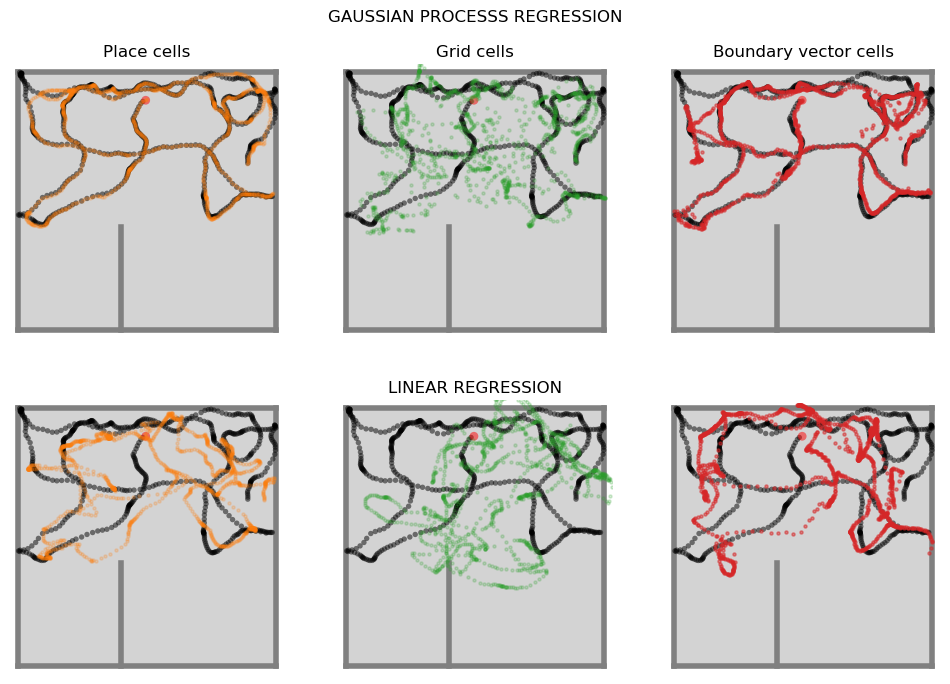

In [10]:
fig, ax = plt.subplots(2,3,figsize=(12,8))
Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[0,0],color='black',alpha=0.5)
ax[0,0].scatter(pos_PCs_GP[:,0],pos_PCs_GP[:,1],s=5,c='C1',alpha=0.2,zorder=3.1)
Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[1,0],color='black', alpha=0.5)
ax[1,0].scatter(pos_PCs_LR[:,0],pos_PCs_LR[:,1],s=5,c='C1',alpha=0.2,zorder=3.1)
ax[0,0].set_title("Place cells")

Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[0,1],color='black', alpha=0.5)
ax[0,1].scatter(pos_GCs_GP[:,0],pos_GCs_GP[:,1],s=5,c='C2',alpha=0.2,zorder=3.1)
Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[1,1],color='black', alpha=0.5)
ax[1,1].scatter(pos_GCs_LR[:,0],pos_GCs_LR[:,1],s=5,c='C2',alpha=0.2,zorder=3.1)
ax[0,1].set_title("GAUSSIAN PROCESSS REGRESSION\n\nGrid cells")
ax[1,1].set_title("LINEAR REGRESSION")

Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[0,2],color='black', alpha=0.5)
ax[0,2].scatter(pos_BVCs_GP[:,0],pos_BVCs_GP[:,1],s=5,c='C3',alpha=0.5,zorder=3.1)
Ag.plot_trajectory(t_start=Ag.t-60,fig=fig, ax=ax[1,2],color='black', alpha=0.5)
ax[1,2].scatter(pos_BVCs_LR[:,0],pos_BVCs_LR[:,1],s=5,c='C3',alpha=0.5,zorder=3.1)
ax[0,2].set_title("Boundary vector cells")

if save_plots == True: tpl.saveFigure(fig, "decoded")

Make a big loop which repeats the above analysis but for different numbers of basis features. Plot the average error as a function of number of basis features.  

THIS WILL TAKE A LONG TIME TO RUN 

In [11]:
from tqdm.notebook import tqdm  # notebook compatible loading bars

N_features = [320,160,80,40,20,10,5]
N_repeats = 15

results_array = np.zeros(shape=(3,len(N_features),N_repeats,2))

Env = Environment()
Env.add_wall(np.array([[0.4,0],[0.4,0.4]]))

for (i,N) in enumerate(tqdm(N_features, desc="Features")): 
    for j in tqdm(range(N_repeats),leave=False, desc="Repeats"):
        #Initialise agent and features
        Ag = Agent(Env, params={'dt':50e-3})
        PCs = PlaceCells(Ag,params={'n':N,'description':'gaussian_threshold','widths':0.4})
        GCs = GridCells(Ag,params={'n':N,'gridscale':0.4},)
        BVCs = BoundaryVectorCells(Ag,params={'n':N})

        #Generate training data 
        for _ in range(int(5*60/Ag.dt)):
            Ag.update()
            PCs.update()
            GCs.update()
            BVCs.update()
            
        #Train
        train_decoder(PCs)
        train_decoder(GCs)
        train_decoder(BVCs)

        #Generate test data 
        steps = int(1*60/Ag.dt)
        for _ in range(steps):
            Ag.update()
            PCs.update()
            GCs.update()
            BVCs.update()
            
        #Test
        t, pos_PCs_GP, pos_PCs_LR = decode_position(PCs,t_start=Ag.t-60)
        t, pos_GCs_GP, pos_GCs_LR = decode_position(GCs,t_start=Ag.t-60)
        t, pos_BVCs_GP, pos_BVCs_LR = decode_position(BVCs,t_start=Ag.t-60)
        pos_groundtruth = np.array(Ag.history['pos'])[-steps:,:]

        #Save results (error in cm) for both gaussian process and linear regression
        PC_error_GP = 100*np.linalg.norm(pos_PCs_GP-pos_groundtruth,axis=1).mean()
        GC_error_GP = 100*np.linalg.norm(pos_GCs_GP-pos_groundtruth,axis=1).mean()
        BVC_error_GP = 100*np.linalg.norm(pos_BVCs_GP-pos_groundtruth,axis=1).mean()
        PC_error_LR = 100*np.linalg.norm(pos_PCs_LR-pos_groundtruth,axis=1).mean()
        GC_error_LR = 100*np.linalg.norm(pos_GCs_LR-pos_groundtruth,axis=1).mean()
        BVC_error_LR = 100*np.linalg.norm(pos_BVCs_LR-pos_groundtruth,axis=1).mean()

        results_array[0,i,j,0] = PC_error_GP
        results_array[1,i,j,0] = GC_error_GP
        results_array[2,i,j,0] = BVC_error_GP
        results_array[0,i,j,1] = PC_error_LR
        results_array[1,i,j,1] = GC_error_LR
        results_array[2,i,j,1] = BVC_error_LR


Features:   0%|          | 0/8 [00:00<?, ?it/s]

Repeats:   0%|          | 0/15 [00:00<?, ?it/s]

Repeats:   0%|          | 0/15 [00:00<?, ?it/s]

Repeats:   0%|          | 0/15 [00:00<?, ?it/s]

Repeats:   0%|          | 0/15 [00:00<?, ?it/s]

Repeats:   0%|          | 0/15 [00:00<?, ?it/s]

Repeats:   0%|          | 0/15 [00:00<?, ?it/s]

Repeats:   0%|          | 0/15 [00:00<?, ?it/s]

Repeats:   0%|          | 0/15 [00:00<?, ?it/s]

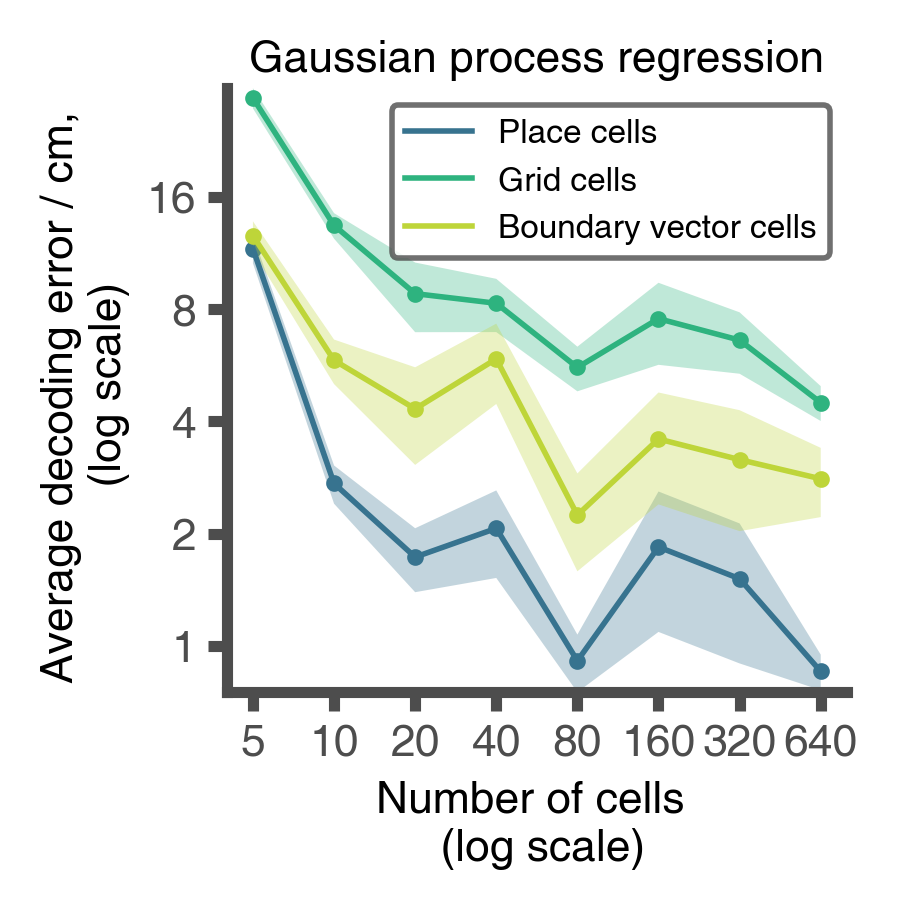

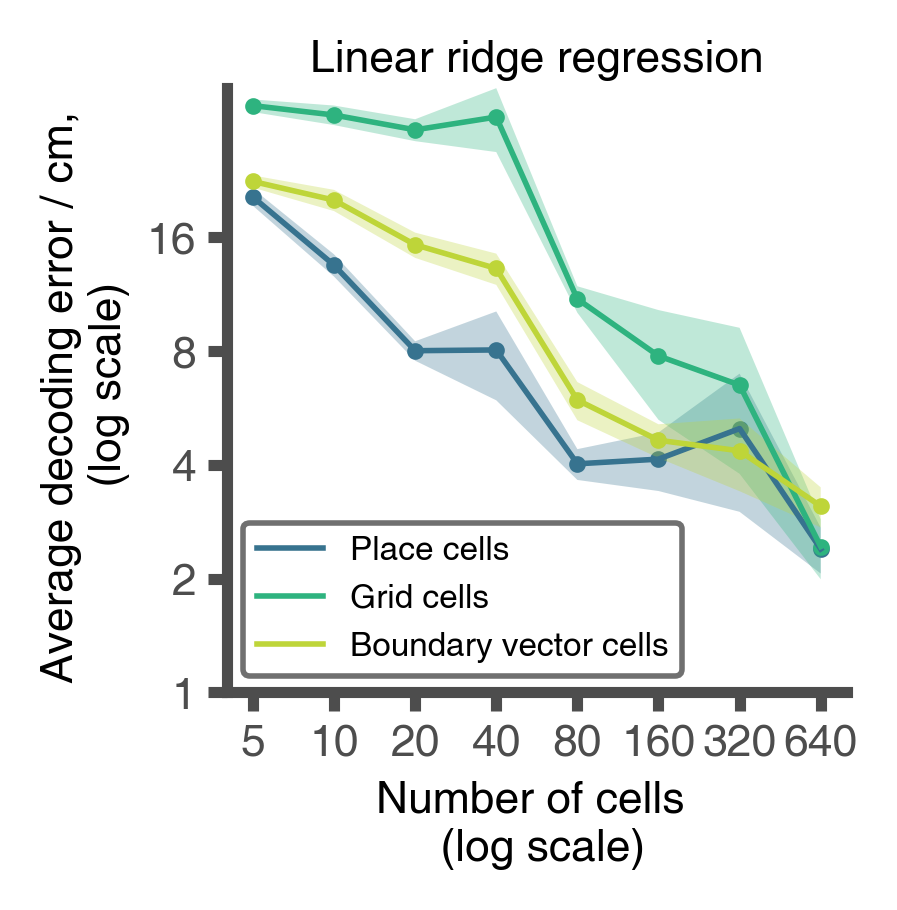

In [24]:
#Get means and std from the results data frame 
means_GP = np.mean(results_array[:,:,:,0],axis=2)
stds_GP = np.std(results_array[:,:,:,0],axis=2) / np.sqrt(15)
means_LR = np.mean(results_array[:,:,:,1],axis=2)
stds_LR = np.std(results_array[:,:,:,1],axis=2) / np.sqrt(15)

#Make figure for Gaussian process regression
fig, ax = plt.subplots()
ax.scatter(N_features,means_GP[0,:],c='C1')
ax.plot(N_features,means_GP[0,:],c='C1',label='Place cells',linewidth=1)
ax.fill_between(N_features,means_GP[0,:]+stds_GP[0,:],means_GP[0,:]-stds_GP[0,:],facecolor='C1',alpha=0.3)

ax.scatter(N_features,means_GP[1,:],c='C2')
ax.plot(N_features,means_GP[1,:],c='C2',label='Grid cells',linewidth=1)
ax.fill_between(N_features,means_GP[1,:]+stds_GP[1,:],means_GP[1,:]-stds_GP[1,:],facecolor='C2',alpha=0.3)

ax.scatter(N_features,means_GP[2,:],c='C3')
ax.plot(N_features,means_GP[2,:],c='C3',label='Boundary vector cells',linewidth=1)
ax.fill_between(N_features,means_GP[2,:]+stds_GP[2,:],means_GP[2,:]-stds_GP[2,:],facecolor='C3',alpha=0.3)

log2_cms = np.logspace(0,4,5,base=2,dtype=int)

ax.set_xlabel("Number of cells \n (log scale)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='y', which='minor', left=False)
ax.set_xbound(lower=N_features[-1]*0.8, upper=N_features[0]/0.8)
ax.set_ylabel("Average decoding error / cm, \n (log scale)")
ax.set_title("Gaussian process regression")
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xticks(N_features)
ax.set_yticks(log2_cms)
ax.set_xticklabels(N_features)
ax.set_yticklabels(log2_cms)
ax.legend()

if save_plots is True: tpl.saveFigure(fig, "GPanalysis")



#Make identical figure for linear ridge regression
fig, ax = plt.subplots()
ax.scatter(N_features,means_LR[0,:],c='C1')
ax.plot(N_features,means_LR[0,:],c='C1',label='Place cells',linewidth=1)
ax.fill_between(N_features,means_LR[0,:]+stds_LR[0,:],means_LR[0,:]-stds_LR[0,:],facecolor='C1',alpha=0.3)

ax.scatter(N_features,means_LR[1,:],c='C2')
ax.plot(N_features,means_LR[1,:],c='C2',label='Grid cells',linewidth=1)
ax.fill_between(N_features,means_LR[1,:]+stds_LR[1,:],means_LR[1,:]-stds_LR[1,:],facecolor='C2',alpha=0.3)

ax.scatter(N_features,means_LR[2,:],c='C3')
ax.plot(N_features,means_LR[2,:],c='C3',label='Boundary vector cells',linewidth=1)
ax.fill_between(N_features,means_LR[2,:]+stds_LR[2,:],means_LR[2,:]-stds_LR[2,:],facecolor='C3',alpha=0.3)

ax.set_xlabel("Number of cells \n (log scale)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(axis='x', which='minor', bottom=False)
ax.tick_params(axis='y', which='minor', left=False)
ax.set_xbound(lower=N_features[-1]*0.8, upper=N_features[0]/0.8)
ax.set_ylabel("Average decoding error / cm, \n (log scale)")
ax.set_title("Linear ridge regression")
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xticks(N_features)
ax.set_yticks(log2_cms)
ax.set_xticklabels(N_features)
ax.set_yticklabels(log2_cms)
ax.legend()

if save_plots is True: tpl.saveFigure(fig, "LRanalysis")